In [3]:
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import resample

In [4]:
AUDIO_DIR = "./SoundAnimals_Train/train"
CSV_PATH = "./SoundAnimals_Train/train.csv"

In [5]:
OUTPUT_DIR = "./SoundAnimals_Train/train_spectograms"

In [6]:
def cargar_csv_y_balancear(csv_path):
    # Leer el archivo CSV
    data = pd.read_csv(csv_path)
    
    # Separar las clases (columnas de animales)
    clases = data.iloc[:, 1:]  # Ignorar la primera columna (nombre de archivo)

    # Identificar la clase mayoritaria
    max_clase = clases.sum().max()

    # Crear un nuevo DataFrame balanceado
    datos_balanceados = []
    for clase in clases.columns:
        clase_data = data[data[clase] == 1]  # Filtrar audios que tienen esta clase
        if len(clase_data) > 0:
            # Sobremuestrear clases minoritarias
            clase_data_resampleada = resample(
                clase_data,
                replace=True,  # Permitir duplicados
                n_samples=max_clase,  # Igualar al número de la clase mayoritaria
                random_state=42
            )
            datos_balanceados.append(clase_data_resampleada)

    # Concatenar todos los datos balanceados
    data_balanceada = pd.concat(datos_balanceados)
    return data_balanceada

In [7]:
def preprocesar_audios_y_generar_espectrogramas(audio_dir, csv_path, output_dir):
    # Crear carpeta de salida si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Cargar CSV balanceado
    data_balanceada = cargar_csv_y_balancear(csv_path)

    for index, row in data_balanceada.iterrows():
        archivo_audio = row[0]  # Primera columna: nombre del archivo
        ruta_audio = os.path.join(audio_dir, archivo_audio)

        if os.path.exists(ruta_audio):
            try:
                # Cargar el audio
                y, sr = librosa.load(ruta_audio, sr=None)
                
                # Generar espectrograma Mel
                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
                mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

                # Guardar el espectrograma como imagen
                plt.figure(figsize=(4, 4))
                plt.axis('off')
                plt.imshow(mel_spectrogram_db, aspect='auto', origin='lower', cmap='viridis')
                nombre_salida = os.path.splitext(archivo_audio)[0] + ".png"
                plt.savefig(os.path.join(output_dir, nombre_salida), bbox_inches='tight', pad_inches=0)
                plt.close()

            except Exception as e:
                print(f"Error al procesar {archivo_audio}: {e}")

In [8]:
preprocesar_audios_y_generar_espectrogramas(AUDIO_DIR, CSV_PATH, OUTPUT_DIR)

: 

In [8]:
def verificar_faltantes(audio_dir, output_dir, missing_csv_path):
    # Obtener lista de archivos de audio
    audios = set([archivo for archivo in os.listdir(audio_dir) if archivo.endswith(".wav")])

    # Obtener lista de imágenes generadas
    imagenes = set([os.path.splitext(archivo)[0] + ".wav" for archivo in os.listdir(output_dir) if archivo.endswith(".png")])

    # Identificar audios faltantes
    faltantes = audios - imagenes

    # Guardar los nombres de los audios faltantes en un CSV
    faltantes_df = pd.DataFrame(list(faltantes), columns=["Archivo de Audio Faltante"])
    faltantes_df.to_csv(missing_csv_path, index=False)

    print(f"Número de audios procesados: {len(audios)}")
    print(f"Número de imágenes generadas: {len(imagenes)}")
    print(f"Número de audios faltantes: {len(faltantes)}")

In [9]:
MISSING_CSV_PATH = "./audios_faltantes2.csv"

In [11]:
verificar_faltantes(AUDIO_DIR, OUTPUT_DIR, MISSING_CSV_PATH)

Número de audios procesados: 62191
Número de imágenes generadas: 62191
Número de audios faltantes: 0


In [11]:
def convertir_audios_faltantes(missing_csv_path, audio_dir, output_dir, batch_size=10000):
    # Leer el CSV de los audios faltantes
    faltantes_df = pd.read_csv(missing_csv_path)
    faltantes = faltantes_df["Archivo de Audio Faltante"].tolist()

    # Dividir los audios en lotes
    for i in range(0, len(faltantes), batch_size):
        batch = faltantes[i:i+batch_size]
        print(f"Procesando lote {i // batch_size + 1} de {len(faltantes) // batch_size + 1}...")

        for archivo_audio in batch:
            ruta_audio = os.path.join(audio_dir, archivo_audio)

            if os.path.exists(ruta_audio):
                try:
                    # Cargar el audio
                    y, sr = librosa.load(ruta_audio, sr=None)

                    # Generar espectrograma Mel
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
                    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

                    # Guardar el espectrograma como imagen
                    plt.figure(figsize=(4, 4))
                    plt.axis('off')
                    plt.imshow(mel_spectrogram_db, aspect='auto', origin='lower', cmap='viridis')
                    nombre_salida = os.path.splitext(archivo_audio)[0] + ".png"
                    plt.savefig(os.path.join(output_dir, nombre_salida), bbox_inches='tight', pad_inches=0)
                    plt.close()

                except Exception as e:
                    print(f"Error al procesar {archivo_audio}: {e}")

In [14]:
convertir_audios_faltantes(MISSING_CSV_PATH, AUDIO_DIR, OUTPUT_DIR, batch_size=10000)

Procesando lote 1 de 5...
Procesando lote 2 de 5...
Procesando lote 3 de 5...
Procesando lote 4 de 5...
Procesando lote 5 de 5...


In [13]:
import pandas as pd
import os

# Rutas
CSV_ORIGINAL = "./SoundAnimals_Train/train.csv"  # CSV original con nombres de audios
OUTPUT_CSV = "./SoundAnimals_Train/train_spectograms.csv"  # Nuevo CSV para las imágenes

# Cargar el CSV original
data = pd.read_csv(CSV_ORIGINAL)

# Reemplazar extensión .wav por .png
data['filename'] = data['filename'].str.replace('.wav', '.png')

# Guardar el nuevo CSV
data.to_csv(OUTPUT_CSV, index=False)

print(f"Nuevo CSV generado: {OUTPUT_CSV}")

/var/folders/fx/n685hk8x7534hjymvry9354c0000gn/T/ipykernel_1227/2826279843.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['filename'] = data['filename'].str.replace('.wav', '.png')


Nuevo CSV generado: ./SoundAnimals_Train/train_spectograms.csv


In [14]:
from PIL import Image
import os

# Directorio donde están las imágenes
IMAGES_DIR = "./SoundAnimals_Train/train_spectograms"

# Verificar dimensiones de las imágenes
dimensiones = []

for imagen in os.listdir(IMAGES_DIR):
    if imagen.endswith(".png"):
        ruta_imagen = os.path.join(IMAGES_DIR, imagen)
        with Image.open(ruta_imagen) as img:
            dimensiones.append(img.size)  # (ancho, alto)

# Mostrar las dimensiones únicas
dimensiones_unicas = set(dimensiones)
print(f"Dimensiones únicas: {dimensiones_unicas}")

# Mostrar cuántas imágenes hay de cada dimensión
from collections import Counter
conteo_dimensiones = Counter(dimensiones)
print(f"Conteo de dimensiones: {conteo_dimensiones}")

Dimensiones únicas: {(310, 308)}
Conteo de dimensiones: Counter({(310, 308): 62191})


SPHSUR    13258
BOABIS    10888
SCIPER     3791
DENNAH      467
LEPLAT     5244
RHIICT      310
BOALEP      846
BOAFAB     6438
PHYCUV     4240
DENMIN     6070
ELABIC     1214
BOAPRA      480
DENCRU      602
BOALUN     2060
BOAALB     3704
PHYMAR      200
PITAZU     4873
PHYSAU     1479
LEPFUS     1232
DENNAN     3801
PHYALB     5374
LEPLAB     1329
SCIFUS        0
BOARAN     1339
SCIFUV     2734
AMEPIC       68
LEPPOD     6032
ADEDIP      390
ELAMAT      395
PHYNAT      410
LEPELE       34
RHISCI       11
SCINAS        0
LEPNOT     1062
ADEMAR      520
BOAALM     1601
PHYDIS      897
RHIORN       21
LEPFLA        7
SCIRIZ       73
DENELE      149
SCIALT      232
dtype: int64


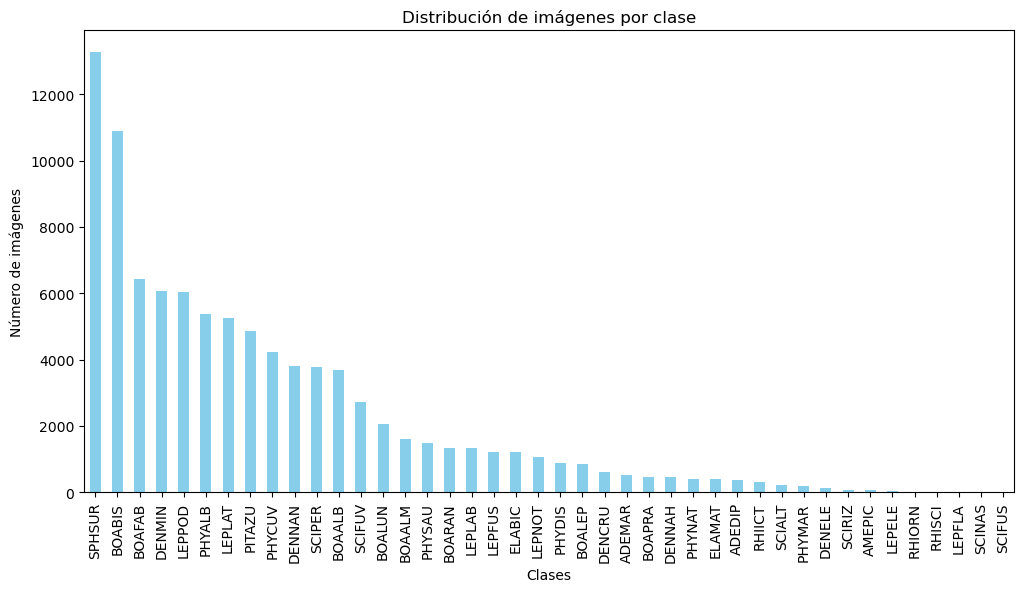

In [42]:
import pandas as pd

# Ruta al CSV con las imágenes y etiquetas
IMAGES_CSV = "./SoundAnimals_Train/train_spectograms.csv"

# Leer el CSV
data = pd.read_csv(IMAGES_CSV)

# Sumar cuántas imágenes hay por clase
conteo_clases = data.iloc[:, 1:].sum()  # Asumiendo que las etiquetas están a partir de la segunda columna

# Mostrar el conteo
print(conteo_clases)

# Visualizar gráficamente
import matplotlib.pyplot as plt

conteo_clases.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6), color="skyblue")
plt.title("Distribución de imágenes por clase")
plt.ylabel("Número de imágenes")
plt.xlabel("Clases")
plt.show()

SPHSUR    13258
BOABIS    10888
SCIPER     3791
DENNAH      467
LEPLAT     5244
RHIICT      310
BOALEP      846
BOAFAB     6438
PHYCUV     4240
DENMIN     6070
ELABIC     1214
BOAPRA      480
DENCRU      602
BOALUN     2060
BOAALB     3704
PHYMAR      200
PITAZU     4873
PHYSAU     1479
LEPFUS     1232
DENNAN     3801
PHYALB     5374
LEPLAB     1329
SCIFUS        0
BOARAN     1339
SCIFUV     2734
AMEPIC       68
LEPPOD     6032
ADEDIP      390
ELAMAT      395
PHYNAT      410
LEPELE       34
RHISCI       11
SCINAS        0
LEPNOT     1062
ADEMAR      520
BOAALM     1601
PHYDIS      897
RHIORN       21
LEPFLA        7
SCIRIZ       73
DENELE      149
SCIALT      232
dtype: int64


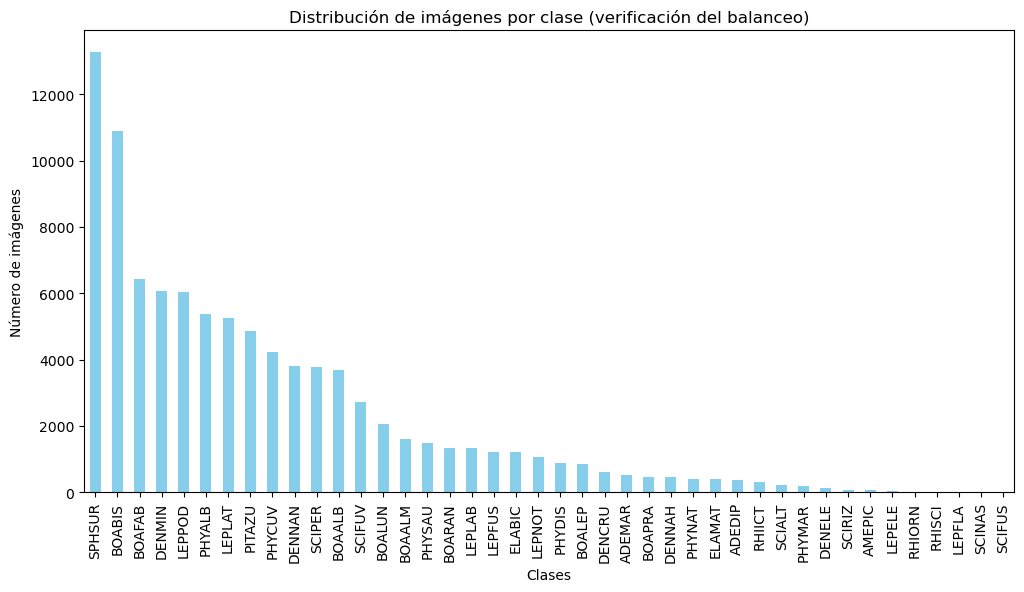

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta al CSV que asocia las imágenes con las etiquetas
IMAGES_CSV = "./SoundAnimals_Train/train_spectograms.csv"

# Leer el CSV
data = pd.read_csv(IMAGES_CSV)

# Calcular cuántas imágenes hay por clase
conteo_clases = data.iloc[:, 1:].sum()  # Asumiendo que las etiquetas están desde la segunda columna

# Mostrar el conteo
print(conteo_clases)

# Visualizar gráficamente la distribución de las clases
conteo_clases.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6), color="skyblue")
plt.title("Distribución de imágenes por clase (verificación del balanceo)")
plt.ylabel("Número de imágenes")
plt.xlabel("Clases")
plt.show()

In [17]:
IMAGES_DIR = "./SoundAnimals_Train/train_spectograms"
AUDIO_DIR = "./SoundAnimals_Train/train"
CSV_ORIGINAL = "./SoundAnimals_Train/train.csv"

In [20]:
def verificar_coherencia(csv_path, audio_dir, images_dir):
    # Leer el archivo CSV original
    data = pd.read_csv(csv_path)
    
    # Listar nombres de audios e imágenes
    audios = set([archivo for archivo in os.listdir(audio_dir) if archivo.endswith(".wav")])
    imagenes = set([archivo for archivo in os.listdir(images_dir) if archivo.endswith(".png")])

    # Verificar registros en el CSV
    registros_sin_audio = []
    registros_sin_imagen = []

    for index, row in data.iterrows():
        audio_nombre = row["filename"]
        audio_nombre_wav = audio_nombre if audio_nombre.endswith(".wav") else f"{audio_nombre}.wav"
        imagen_nombre_png = audio_nombre.replace(".wav", ".png")

        if audio_nombre_wav not in audios:
            registros_sin_audio.append(audio_nombre_wav)
        if imagen_nombre_png not in imagenes:
            registros_sin_imagen.append(imagen_nombre_png)

    # Mostrar resultados
    print(f"Registros sin audio: {len(registros_sin_audio)}")
    print(f"Registros sin imagen: {len(registros_sin_imagen)}")

    # Guardar resultados
    pd.DataFrame(registros_sin_audio, columns=["Audio sin archivo"]).to_csv("registros_sin_audio.csv", index=False)
    pd.DataFrame(registros_sin_imagen, columns=["Imagen sin archivo"]).to_csv("registros_sin_imagen.csv", index=False)
    
    print("Resultados guardados en 'registros_sin_audio.csv' y 'registros_sin_imagen.csv'")



In [21]:
verificar_coherencia(CSV_ORIGINAL, AUDIO_DIR, IMAGES_DIR)

Registros sin audio: 0
Registros sin imagen: 0
Resultados guardados en 'registros_sin_audio.csv' y 'registros_sin_imagen.csv'


In [61]:
CSV_ORIGINAL = "./SoundAnimals_Train/train_spectograms.csv"
CSV_BALANCEADO = "./SoundAnimals_Train/train_final.csv"

In [50]:
from sklearn.utils import resample
import math

In [66]:
def cargar_csv_y_balancear_personalizado(csv_path, output_csv_path, limite_min=6000):
    # Leer el archivo CSV
    data = pd.read_csv(csv_path)
    
    # Separar las clases (columnas de animales)
    clases = data.iloc[:, 1:]  # Ignorar la primera columna (nombre de archivo)

    # Crear un nuevo DataFrame balanceado con límite mínimo
    datos_balanceados = []
    for clase in clases.columns:
        clase_data = data[data[clase] == 1]  # Filtrar audios que tienen esta clase
        num_registros = len(clase_data)
        print(f"Clase {clase}: {num_registros} registros")

        if num_registros == 0:
            print(f"La clase {clase} no tiene registros y será omitida.")
            continue

        if num_registros >= limite_min:
            # Mantener las clases con más de limite_min registros tal cual
            datos_balanceados.append(clase_data)
            print(f"La clase {clase} tiene suficientes registros.")
        else:
            # Duplicar o triplicar hasta aproximarse a limite_min
            factor = math.ceil(limite_min / num_registros)  # Calcular cuántas veces duplicar
            print(f"Factor de duplicación para la clase {clase}: {factor}")
            clase_data_resampleada = pd.concat([clase_data] * factor, ignore_index=True)  # Duplicar
            
            clase_data_resampleada = clase_data_resampleada.sample(n=limite_min, random_state=42, replace=False)  # Limitar a limite_min
            print(f"La clase {clase} ha sido duplicada a {len(clase_data_resampleada)} registros.")
            datos_balanceados.append(clase_data_resampleada)

    # Concatenar todos los datos balanceados
    data_balanceada = pd.concat(datos_balanceados)

    # Guardar el CSV balanceado
    data_balanceada.to_csv(output_csv_path, index=False)
    print(f"CSV balanceado guardado en: {output_csv_path}")

In [67]:
cargar_csv_y_balancear_personalizado(CSV_ORIGINAL, CSV_BALANCEADO, limite_min=6000)



Clase SPHSUR: 13258 registros
La clase SPHSUR tiene suficientes registros.
Clase BOABIS: 10888 registros
La clase BOABIS tiene suficientes registros.
Clase SCIPER: 3791 registros
Factor de duplicación para la clase SCIPER: 2
La clase SCIPER ha sido duplicada a 6000 registros.
Clase DENNAH: 467 registros
Factor de duplicación para la clase DENNAH: 13
La clase DENNAH ha sido duplicada a 6000 registros.
Clase LEPLAT: 5244 registros
Factor de duplicación para la clase LEPLAT: 2
La clase LEPLAT ha sido duplicada a 6000 registros.
Clase RHIICT: 310 registros
Factor de duplicación para la clase RHIICT: 20
La clase RHIICT ha sido duplicada a 6000 registros.
Clase BOALEP: 846 registros
Factor de duplicación para la clase BOALEP: 8
La clase BOALEP ha sido duplicada a 6000 registros.
Clase BOAFAB: 6438 registros
La clase BOAFAB tiene suficientes registros.
Clase PHYCUV: 4240 registros
Factor de duplicación para la clase PHYCUV: 2
La clase PHYCUV ha sido duplicada a 6000 registros.
Clase DENMIN: 6

In [30]:
def contar_registros_csv(csv_path):
    # Leer el archivo CSV
    data = pd.read_csv(csv_path)
    print(f"Cantidad total de registros en el CSV: {len(data)}")

In [65]:
contar_registros_csv(CSV_BALANCEADO)

Cantidad total de registros en el CSV: 252686


In [47]:
def verificar_registros_por_clase(csv_path):
    # Leer el CSV balanceado
    data = pd.read_csv(csv_path)

    # Contar registros por clase
    conteo_clases = data.iloc[:, 1:].sum()
    print(conteo_clases)

    # Visualizar gráficamente
    import matplotlib.pyplot as plt
    conteo_clases.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6), color="skyblue")
    plt.title("Distribución de registros por clase (CSV balanceado)")
    plt.ylabel("Número de registros")
    plt.xlabel("Clases")
    plt.show()

SPHSUR    64822
BOABIS    47337
SCIPER    25972
DENNAH     8770
LEPLAT    24952
RHIICT     7493
BOALEP     9391
BOAFAB    38806
PHYCUV    34392
DENMIN    48569
ELABIC    11490
BOAPRA     7921
DENCRU     8193
BOALUN    14389
BOAALB    14924
PHYMAR     6576
PITAZU    36430
PHYSAU    15843
LEPFUS    13247
DENNAN    37663
PHYALB    57774
LEPLAB    18223
SCIFUS        0
BOARAN    17933
SCIFUV    33733
AMEPIC     6128
LEPPOD    32976
ADEDIP     6994
ELAMAT    13755
PHYNAT    12303
LEPELE     6311
RHISCI     6111
SCINAS        0
LEPNOT     9296
ADEMAR     6949
BOAALM    15534
PHYDIS    10603
RHIORN     6000
LEPFLA     6000
SCIRIZ     6103
DENELE     6403
SCIALT     6562
dtype: int64


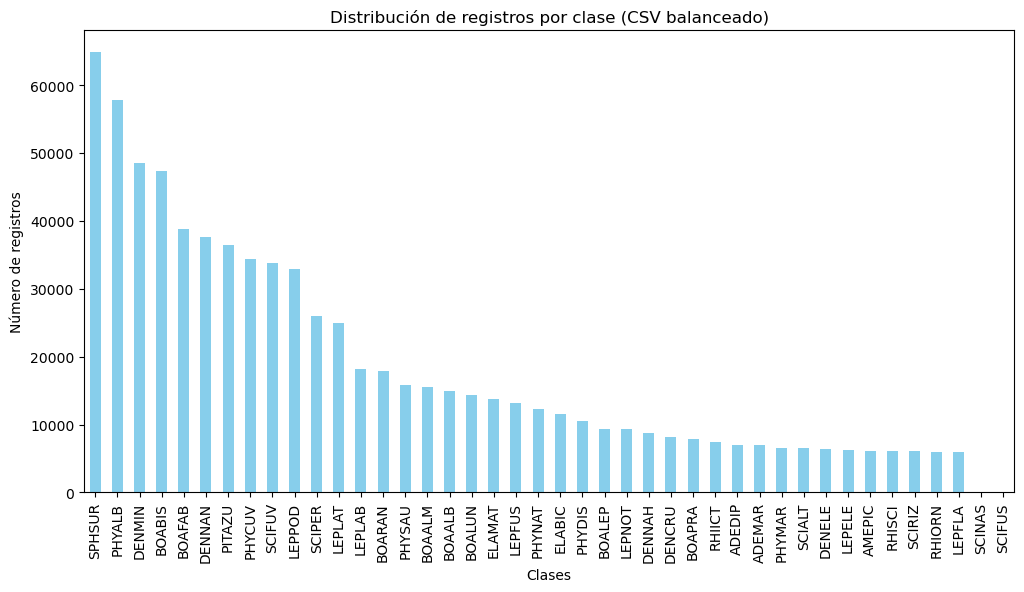

In [68]:
verificar_registros_por_clase(CSV_BALANCEADO)